# 原始CGN数据 清洗/切片/对齐/保存中间件

ptbxl_database.csv 前5行:


,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


scp_statements.csv 前5行:


,Unnamed: 0,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
0,NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
1,NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
2,DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
3,LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
4,NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


/opt/anaconda3/envs/tf/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35786 (\N{CJK UNIFIED IDEOGRAPH-8BCA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/tf/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26029 (\N{CJK UNIFIED IDEOGRAPH-65AD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/tf/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/tf/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/tf/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDE

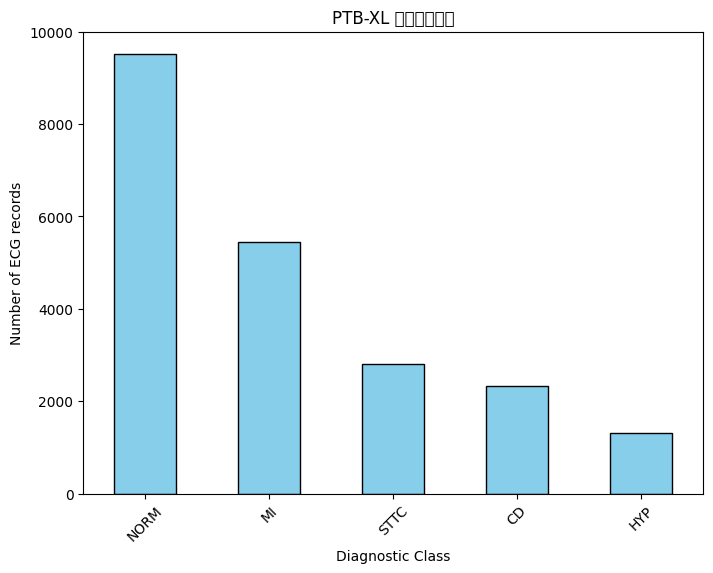

In [2]:
# Notebook: visualize_ptbxl.ipynb

import pandas as pd
import matplotlib.pyplot as plt

# 1. 读取 CSV 文件
ptbxl_db = pd.read_csv("../data/ptb_xl_ecg/ptbxl_database.csv")
scp_df = pd.read_csv("../data/ptb_xl_ecg/scp_statements.csv")

print("ptbxl_database.csv 前5行:")
display(ptbxl_db.head())

print("scp_statements.csv 前5行:")
display(scp_df.head())

# 2. 将 ptbxl_database 中的 scp_codes（JSON字符串）转成字典
import ast

def extract_first_scp(scp_str):
    """把字符串形式的dict转为真正的dict，并返回第一个scp code"""
    try:
        scp_dict = ast.literal_eval(scp_str)
        if isinstance(scp_dict, dict) and len(scp_dict) > 0:
            return list(scp_dict.keys())[0]
    except:
        return None
    return None

ptbxl_db['first_scp'] = ptbxl_db['scp_codes'].apply(extract_first_scp)

# 3. 合并诊断类别
merged = ptbxl_db.merge(scp_df, left_on="first_scp", right_on="Unnamed: 0", how="left")

# 4. 按诊断分类统计数量
diag_counts = merged['diagnostic_class'].value_counts()

# 5. 可视化
plt.figure(figsize=(8,6))
diag_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("PTB-XL 诊断类别分布")
plt.xlabel("Diagnostic Class")
plt.ylabel("Number of ECG records")
plt.xticks(rotation=45)
plt.show()
